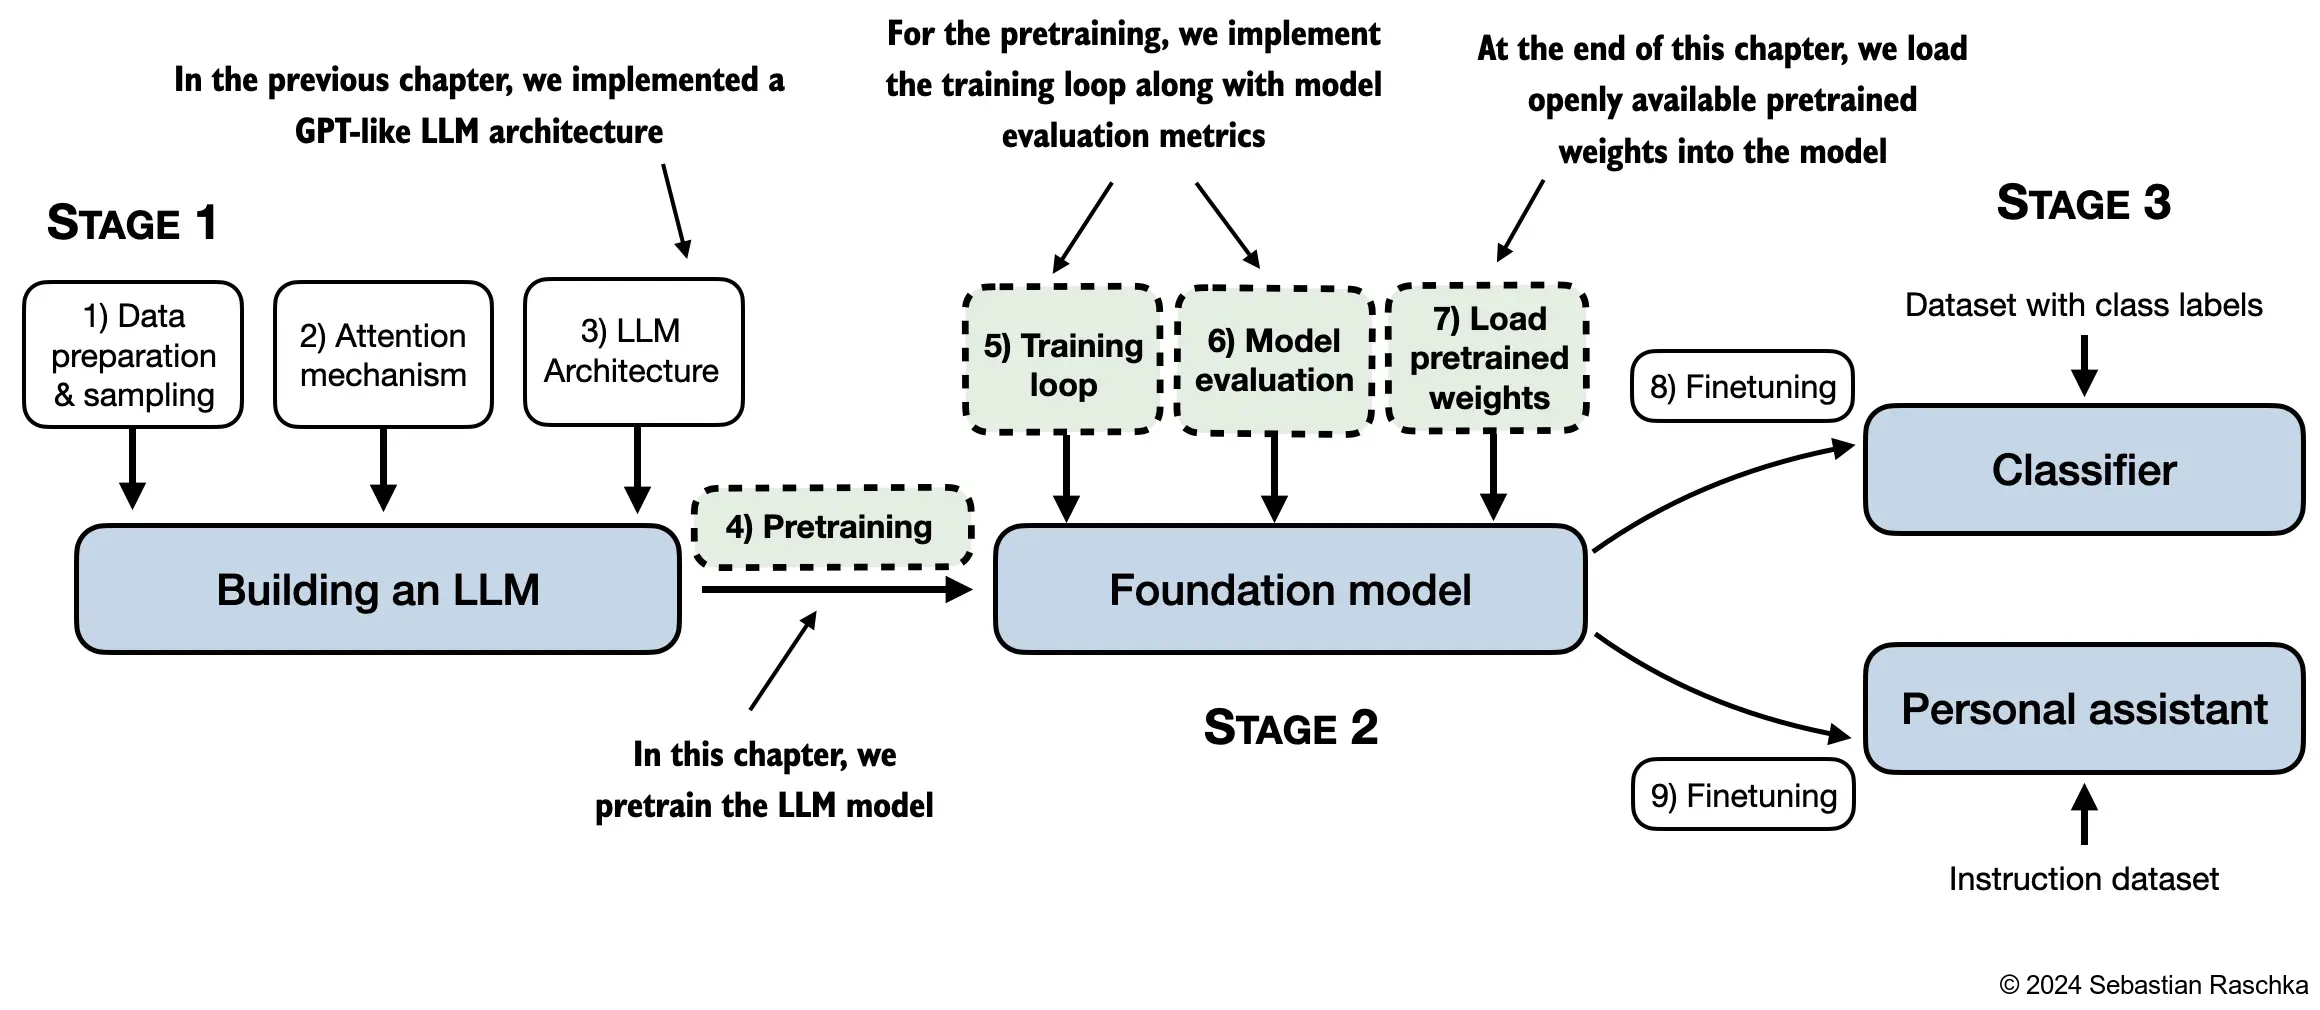

# Training an LLM

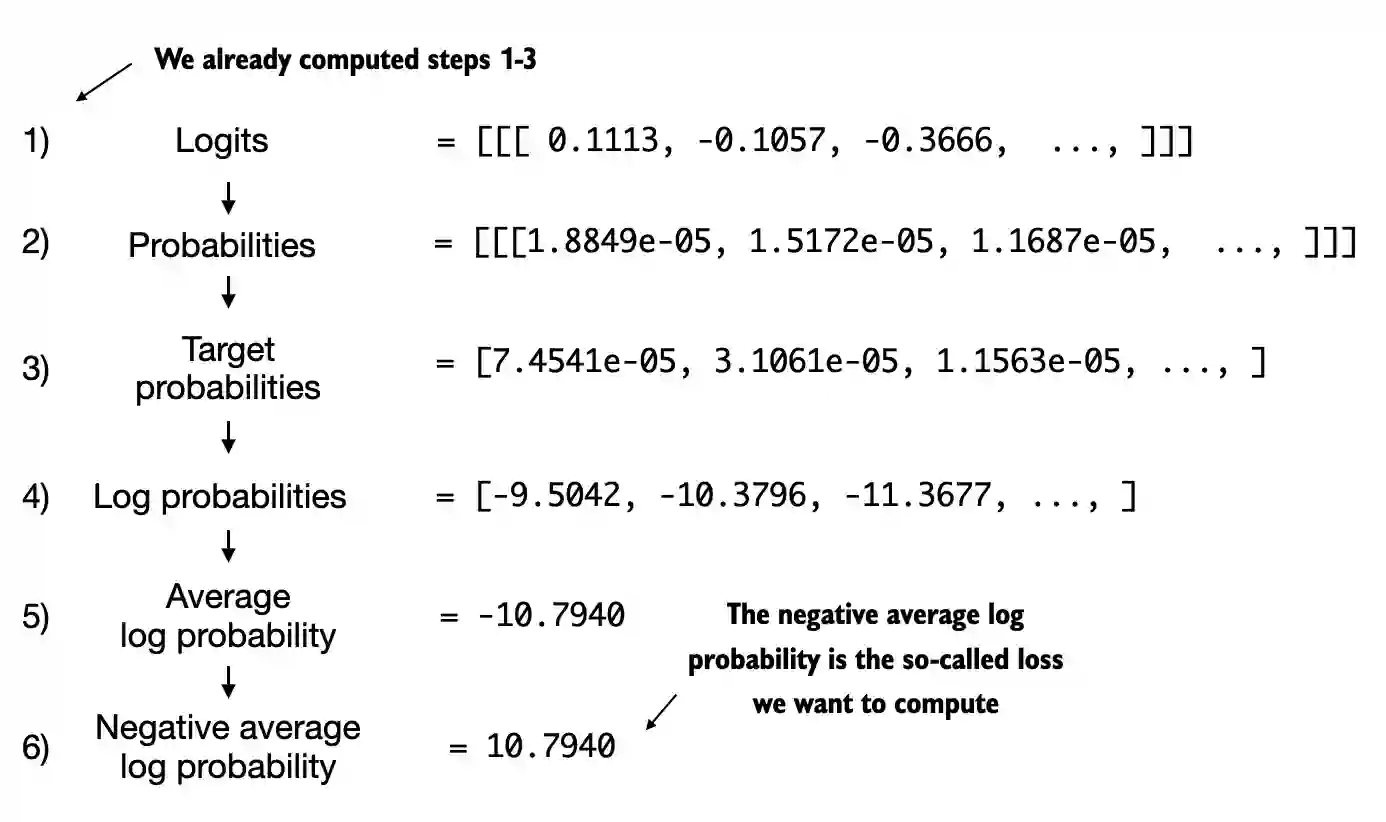

In [55]:
from test_diy import GPT2
from test_diy.GPT2 import GPTModel
import torch.nn as nn
import torch


GPT_CONFIG_124M = {
        "vocab_size": 50527,    # 词汇个数
        "context_length": 256, # sample的长度
        "emb_dim": 768,         # 嵌入维度
        "n_heads": 12,          # 注意力头数
        "n_layers": 12,         # 层数
        "drop_rate": 0.1,       # 权重丢失率
        "qkv_bias": False       # Query-Key-Value偏执设置
    }

model = GPTModel(GPT_CONFIG_124M)
print(model)

GPTModel(
  (tok_emb): Embedding(50527, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features

In [56]:
import os
import urllib.request

file_path = "data/the-verdict.txt"
url = "https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/the-verdict.txt"
if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

print(text_data[:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [57]:
from torch.utils.data import Dataset, DataLoader
import tiktoken

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        super().__init__()
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index] 

def create_dataloader_v1(txt, max_length=256, stride=128,
                         batch_size=4, shuffle=True, drop_last=True, num_workers=0):
    
    tokenizer = tiktoken.get_encoding('gpt2')

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle,    # PyTorch 的 DataLoader(shuffle=True) 仅打乱不同样本（如句子、文本块）的顺序，不会破坏单个样本内部的词序 。
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [58]:
print(len(text_data))

20479


In [59]:
train_ratio = 0.90
splite_idx = int(train_ratio * len(text_data))
train_data = text_data[:splite_idx]
val_data = text_data[splite_idx:]
print(len(val_data))

torch.manual_seed(42)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

2048


In [60]:
tokenizer = tiktoken.get_encoding('gpt2')

total_tokens = len(tokenizer.encode(text_data))

if total_tokens * train_ratio < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [61]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader)==0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader) # 默认全部批次
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches # num_batches出一个损失值， 默认是整个dataloader出一个损失值

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(42)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(train_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.997020191616482
Validation loss: 10.998968018425835


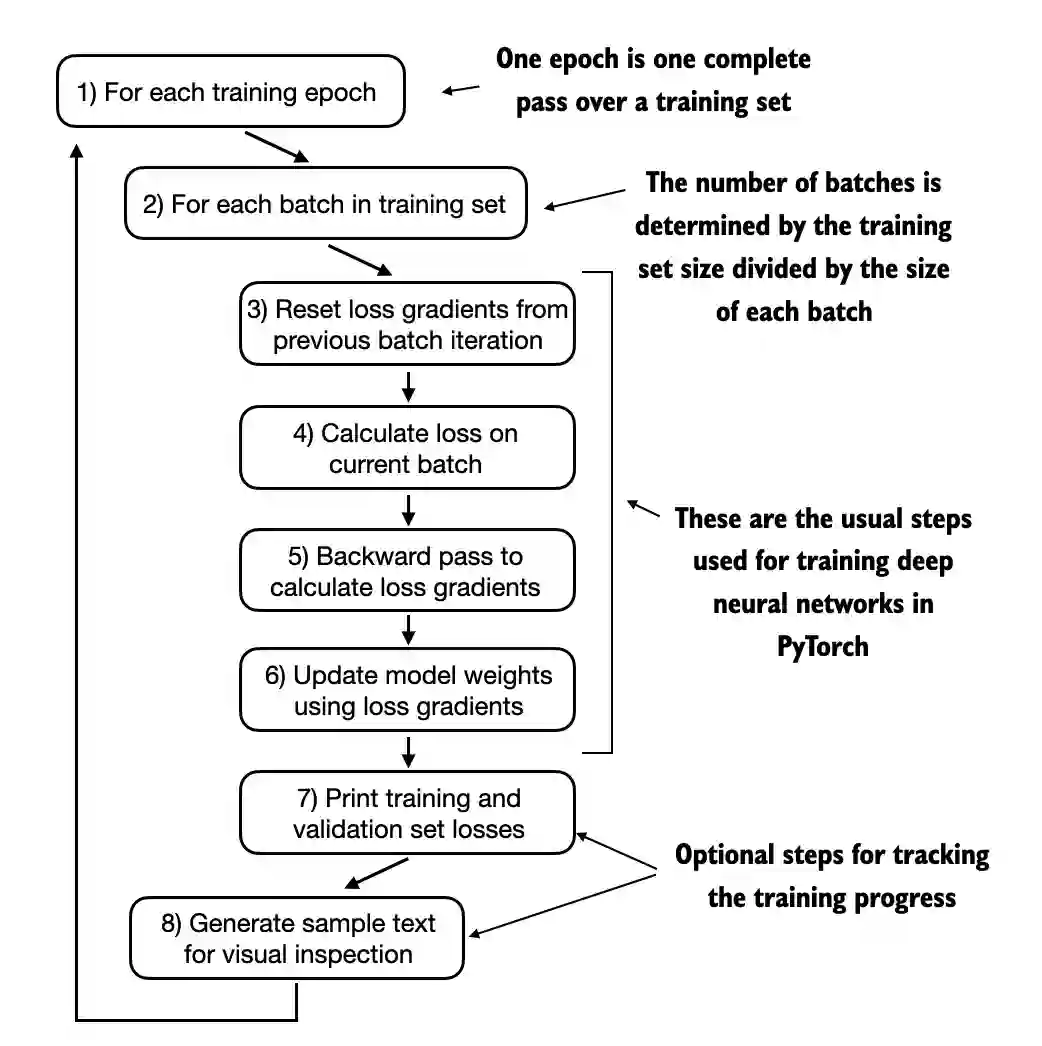

In [63]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 变为batch
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 变成context
    return tokenizer.decode(flat.tolist())


In [64]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        # 只能通过context——size个token预测下一个token
        idx_cond = idx[:, -context_size:] 
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)    ### batch_size, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


In [65]:
def train_model_simple(model, train_loader, val_loader, optimiazer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            # 清除模型参数的梯度缓存 ，确保每次参数更新都基于当前批次数据计算的新梯度。
            optimiazer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimiazer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq==0: # eval_ferquent个batch，输出一次损失情况
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader,  model, device, eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0] # 获取模型的最大上下文窗口大小, 在生成文本时，确保不会超过模型的序列处理能力
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()



In [ ]:
import time

start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000):Train loss 10.112, Val loss 10.072
Ep 1 (Step 000005):Train loss 8.188, Val loss 8.320
Every effort moves you, the, the, the, the, the, the,, the, the, the,, the, the, the, the, the, the the, the, the, the, the, the, the,, the, the
Ep 2 (Step 000010):Train loss 6.696, Val loss 7.038
Ep 2 (Step 000015):Train loss 6.157, Val loss 6.592
Every effort moves you.                                                 
Ep 3 (Step 000020):Train loss 5.712, Val loss 6.430
Ep 3 (Step 000025):Train loss 5.663, Val loss 6.477
Every effort moves you a                                                 
Ep 4 (Step 000030):Train loss 5.416, Val loss 6.453
Ep 4 (Step 000035):Train loss 5.093, Val loss 6.321
Every effort moves you--""I a a a--I--I"--I. "--I. "--I was, and, and I had the a a to the a a--I, and, and he was, and I had
Ep 5 (Step 000040):Train loss 4.593, Val loss 6.385
Every effort moves you.                                                 
Ep 6 (Step 000045):Train loss 4.205, Va

In [67]:
# 在代码中添加显存监控
torch.cuda.empty_cache()
print(f"当前显存占用: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

当前显存占用: 2.30GB


In [68]:
print(f"当前显存占用: {torch.cuda.memory_reserved()/1024**3:.2f}GB")

当前显存占用: 2.78GB


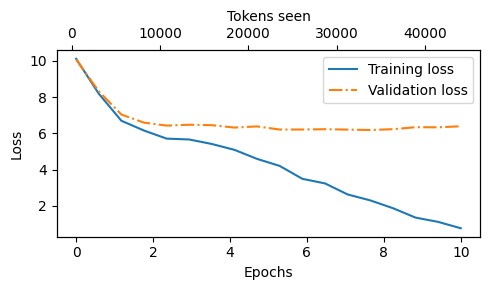

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Decoding strategies to control randomness

**1. temperature scaling**：根据概率分布在Probas（Logits）中进行随机抽样，Sampling the next token

**2. top-k sampling**

让预测输出变得有意义

In [72]:
print(model)

GPTModel(
  (tok_emb): Embedding(50527, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features

In [73]:
model.to("cpu")
model.eval()


tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 Every effort moves you?"

"Yes--quite insensible to the fact with a Stroud so when she began to me--




In [82]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v:k for k, v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.98, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])
print(probas)

forward
tensor([6.0908e-02, 1.6313e-03, 1.0019e-04, 5.7213e-01, 3.4190e-03, 1.3257e-04,
        9.2491e-05, 3.5758e-01, 4.0123e-03])


In [81]:
torch.manual_seed(42)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(42)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    print(sample)
    for i, freq in enumerate(sample_ids):
        print(f"{freq}, {inverse_vocab[i]}")

print_sampled_tokens(probas)

tensor([ 62,   0,   0, 560,   4,   0,   0, 370,   4])
62, closer
0, every
0, effort
560, forward
4, inches
0, moves
0, pizza
370, toward
4, you


## temperature

In [86]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.5, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
print(scaled_probas)

[tensor([6.0908e-02, 1.6313e-03, 1.0019e-04, 5.7213e-01, 3.4190e-03, 1.3257e-04,
        9.2491e-05, 3.5758e-01, 4.0123e-03]), tensor([8.0834e-03, 5.7983e-06, 2.1875e-08, 7.1324e-01, 2.5472e-05, 3.8295e-08,
        1.8640e-08, 2.7861e-01, 3.5078e-05]), tensor([0.1548, 0.0750, 0.0429, 0.2422, 0.0870, 0.0454, 0.0423, 0.2205, 0.0898])]


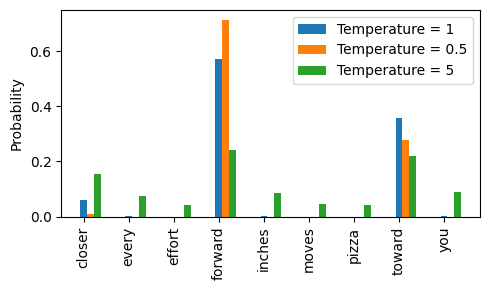

In [87]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

**temperature 越大自由度越高**

**更低的温度更低的熵， 更高的温度更高的熵**

**Small: Sharper distribution & Large: Flattened distribution**

In [92]:
next_token_logits2 = next_token_logits/0.1

probas = torch.softmax(next_token_logits2, dim=0)

print([f"{p:.4f}" for p in probas])

['0.0000', '0.0000', '0.0000', '0.9910', '0.0000', '0.0000', '0.0000', '0.0090', '0.0000']


In [90]:
next_token_logits2 = next_token_logits/5

probas = torch.softmax(next_token_logits2, dim=0)
print(probas)

tensor([0.1548, 0.0750, 0.0429, 0.2422, 0.0870, 0.0454, 0.0423, 0.2205, 0.0898])


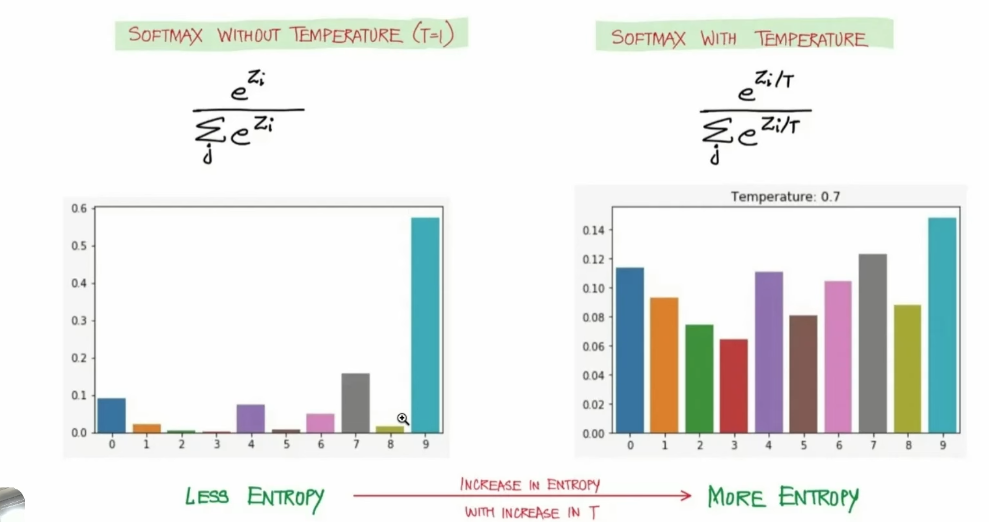

## top-k sampling

将预测范围缩小，下一个可能出现的词的集合是全部词的一部分

topk越大，生成文本自由度越高

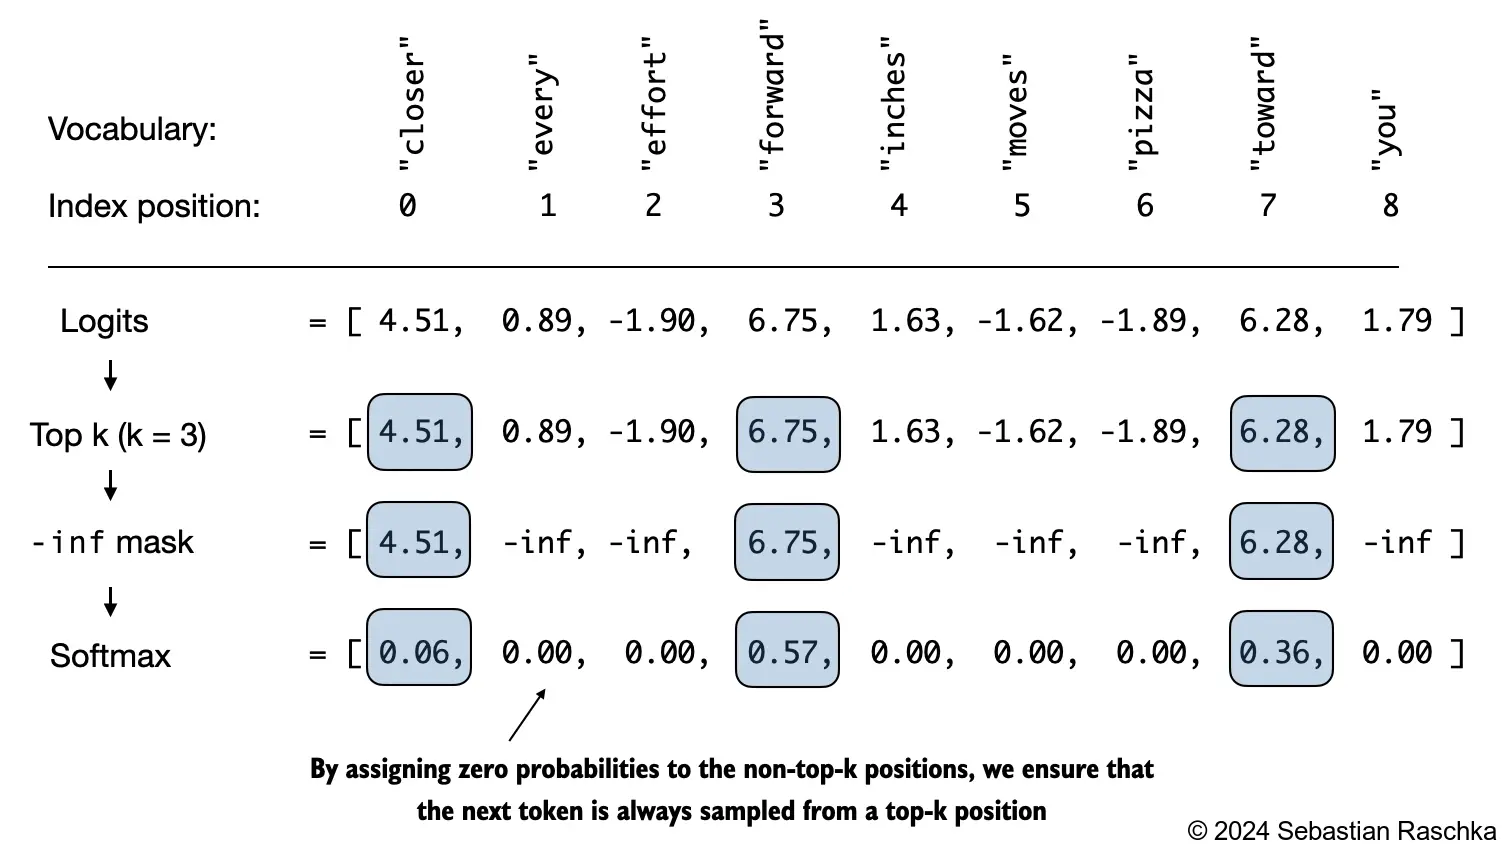

In [93]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.98, 6.28, 1.79]
)

In [94]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logitics:", top_logits)
print("Top positions:", top_pos)

Top logitics: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [ ]:
new_logits = torch.where(
    condition=next_token_logits<top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [96]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [102]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0,
             top_k=None,
             eos_ids=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:] # （batch_size, context_length）

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(condition=logits<min_val,
                                 input=torch.tensor(float("-inf")).to(logits.device),
                                 other=logits)
        
        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            # 根据概率分布进行采样
            idx_next = torch.multinomial(probas, num_samples=1) # (batch_size, 1)

        else:
            idx = torch.argmax(logits, dim=-1, keepdim=True) # (batch_size, 1)
        
        if idx_next == eos_ids: # 停止符
            break

        idx = torch.cat((idx, idx_next), dim=-1) # (batch_sizr, num_tokens+1)

    return idx


In [104]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Outout text:\n", token_ids_to_text(token_ids, tokenizer))

Outout text:
 Every effort moves you know I meant to a Mrs. I half was such
"; and
